<a href="https://colab.research.google.com/github/OrnellaFanais/LinuxDay2021/blob/main/Linux_Day_2021_RL_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Q Network with TF-Agents**


  <a target="_blank" href="https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb">
    Run in Google Colab</a>

The TF-Agents library is a Reinforcement Learning library based on TensorFlow, developed at Google and open sourced in 2018. Just like OpenAI Gym, it provides many off-the-shelf environments, plus it supports the PyBullet library and Unity’s ML-Agents library.


### Setup

In [ ]:
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install gym
!pip install 'imageio==2.4.0'
!pip install PILLOW
!pip install pyglet
!pip install pyvirtualdisplay
!pip install tf-agents
!sudo apt-get update

Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-3).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 68 not upgraded.
Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:2 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:6 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:9 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:10 https://developer.download.nvidia.com/compu

In [ ]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [ ]:
tf.compat.v1.enable_v2_behavior()

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [ ]:
tf.version.VERSION

'2.6.0'

## Using GPUs to Speed Up Computations

<table>
  <tr>
    <th>Parameters</th>
    <th>Tesla K80</th>
    <th>Tesla T4s</th>
    <th>Tesla P4s</th>
    <th>Tesla P100s</th>
  </tr>
  <tr>
    <td>Release date</td>
    <td> 2014 </td>
    <td>2018</td>
    <td>2016</td>
    <td>2016</td>
  </tr>
  <tr>
    <td>Core clock rate [MHz]</td>
    <td>562</td>
    <td>585</td>
    <td>886</td>
    <td>1190</td>
  </tr>
    <tr>
    <td>Boost clock rate [MHz]</td>
    <td>824</td>
    <td>1590</td>
    <td>1114</td>
    <td>1329</td>
  </tr>
    <tr>
    <td>Memory Type</td>
    <td> GDDR5 </td>
    <td>GDDR6</td>
    <td>GDDR5</td>
    <td>HBM2</td>
  </tr>
</table>

You'll need to enable GPUs for the notebook:

*   Navigate to Runtime $\rightarrow$ Change runtime type
*   Notebook Settings $\rightarrow$ select GPU

In [ ]:
model = !nvidia-smi
GPU_model = model[0]
model

['Thu Oct 21 21:20:10 2021       ',
 '+-----------------------------------------------------------------------------+',
 '| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |',
 '|-------------------------------+----------------------+----------------------+',
 '| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |',
 '| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |',
 '|                               |                      |               MIG M. |',
 '|===============================+======================+======================|',
 '|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |',
 '| N/A   42C    P0    58W / 149W |    172MiB / 11441MiB |      0%      Default |',
 '|                               |                      |                  N/A |',
 '+-------------------------------+----------------------+----------------------+',
 '                                      

## Hyperparameters

In [ ]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 500  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

num_iterations = 20000 # @param {type:"integer"}


## Environment

Standard environments can be created in TF-Agents using `tf_agents.environments` suites. 

In [ ]:
env_name = 'Acrobot-v1' #@param ["Acrobot-v1", "CartPole-v1", "MountainCar-v0"]
env = suite_gym.load(env_name)

## Methods 



*   `env.reset()`
*   `env.render()`
*   `env.step()`



In [ ]:
env.reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.9950462 ,  0.09941368,  0.9996464 , -0.02658994,  0.02790684,
        0.05955897], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

In OpenAI Gym - Array 
`(array([ 0.99987675, -0.01570013,  0.99984668,  0.01751027,  0.00964072, 0.08657703]))`



In [ ]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.99903953, -0.04381749,  0.9998157 ,  0.01919773,  0.05467884,
        0.03494037], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.9996183 , -0.02762654,  0.9997943 ,  0.02028099,  0.10402535,
       -0.02170357], dtype=float32),
 'reward': array(-1., dtype=float32),
 'step_type': array(1, dtype=int32)})


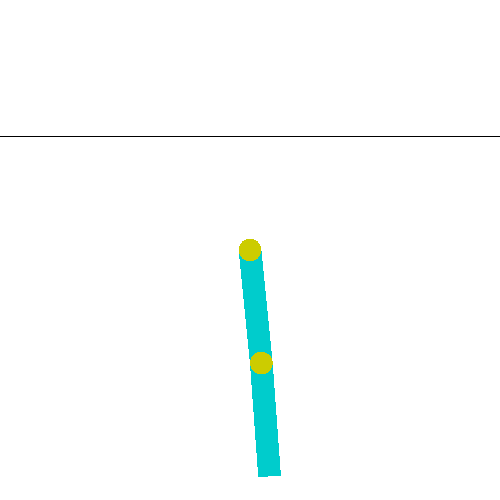

In [ ]:
PIL.Image.fromarray(env.render(mode='rgb_array'))

### Observation and Action Space and Reward

In [ ]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(6,), dtype=dtype('float32'), name='observation', minimum=[ -1.        -1.        -1.        -1.       -12.566371 -28.274334], maximum=[ 1.        1.        1.        1.       12.566371 28.274334])


In [ ]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=2)


In [ ]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


## Development of agent reinforcement learning algorithms

Usually two environments are instantiated: one for training and one for evaluation. 

In [ ]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

The Cartpole environment, like most environments, is written in pure Python. This is converted to TensorFlow using the `TFPyEnvironment` wrapper.

The original environment's API uses Numpy arrays. The `TFPyEnvironment` converts these to `Tensors` to make it compatible with Tensorflow agents and policies.


In [ ]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

At the heart of a DQN Agent is a `QNetwork`, a neural network model that can learn to predict `QValues` (expected returns) for all actions, given an observation from the environment.

Use `tf_agents.networks.q_network` to create a `QNetwork`, passing in the `observation_spec`, `action_spec`, and a tuple describing the number and size of the model's hidden layers.


In [ ]:
fc_layer_params = (100,32,32,100)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

Now use `tf_agents.agents.dqn.dqn_agent` to instantiate a `DqnAgent`. In addition to the `time_step_spec`, `action_spec` and the QNetwork, the agent constructor also requires an optimizer (in this case, `AdamOptimizer`), a loss function, and an integer step counter.

In [ ]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policies

Agents contain two policies: 

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.


In [ ]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

Policies can be created independently of agents. For example, use `tf_agents.policies.random_tf_policy` to create a policy which will randomly select an action for each `time_step`.

In [ ]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

To get an action from a policy, call the `policy.action(time_step)` method. The `time_step` contains the observation from the environment. This method returns a `PolicyStep`, which is a named tuple with three components:

-   `action` — the action to be taken (in this case, `0` or `1`)
-   `state` — used for stateful (that is, RNN-based) policies
-   `info` — auxiliary data, such as log probabilities of actions

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. 

In [ ]:

def compute_avg_return(environment, policy, num_episodes=250):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [ ]:
#compute_avg_return(eval_env, random_policy, num_eval_episodes)

## Replay Buffer

The replay buffer keeps track of data collected from the environment. This tutorial uses `tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer`, as it is the most common. 

The constructor requires the specs for the data it will be collecting. This is available from the agent using the `collect_data_spec` method. The batch size and maximum buffer length are also required.


In [ ]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

For most agents, `collect_data_spec` is a named tuple called `Trajectory`, containing the specs for observations, actions, rewards, and other items.

In [ ]:
#agent.collect_data_spec

In [ ]:
#agent.collect_data_spec._fields

## Data Collection

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

In [ ]:

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

The agent needs access to the replay buffer. This is provided by creating an iterable `tf.data.Dataset` pipeline which will feed data to the agent.

Each row of the replay buffer only stores a single observation step. But since the DQN Agent needs both the current and next observation to compute the loss, the dataset pipeline will sample two adjacent rows for each item in the batch (`num_steps=2`).

This dataset is also optimized by running parallel calls and prefetching data.

In [ ]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

<PrefetchDataset shapes: (Trajectory(
{action: (64, 2),
 discount: (64, 2),
 next_step_type: (64, 2),
 observation: (64, 2, 6),
 policy_info: (),
 reward: (64, 2),
 step_type: (64, 2)}), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(
{action: tf.int64,
 discount: tf.float32,
 next_step_type: tf.int32,
 observation: tf.float32,
 policy_info: (),
 reward: tf.float32,
 step_type: tf.int32}), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [ ]:
iterator = iter(dataset)

print(iterator)


## Training the agent

Two things must happen during the training loop:

-   collect data from the environment
-   use that data to train the agent's neural network(s)

This example also periodicially evaluates the policy and prints the current score.

The following will take ~5 minutes to run.

In [ ]:

try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs
step = 500: loss = 16.58030128479004
step = 1000: loss = 4.6124114990234375
step = 1000: Average Return = -500.0
step = 1500: loss = 6.681689262390137
step = 2000: loss = 8.593046188354492
step = 2000: Average Return = -500.0
step = 2500: loss = 22.83534049987793
step = 3000: loss = 29.743640899658203
step = 3000: Average Return = -500.0
step = 3500: loss = 40.79793930053711
step = 4000: loss = 20.9778995513916
step = 4000: Average Return = -500.0
step = 4500: loss = 14.748577117919922
step = 5000: loss = 27.061508178710938
step = 5000: Average Return = -405.1000061035156
step = 5500: loss = 8.032842636108398
step = 6000: loss = 6.95731782913208
step = 6000: Average Return = -184.39999389648438
step = 6500: loss = 3.214837074279785
step = 7000: loss = 7.836937427520752
step = 7000: Average Return = -113.9000015258789
step = 7500: loss = 8.395828247070312
step = 8000: loss = 4.809001922607422
step = 8000: Average Return

## Visualization


### Plots

Use `matplotlib.pyplot` to chart how the policy improved during training.

One iteration of `Cartpole-v0` consists of 200 time steps. The environment gives a reward of `+1` for each step the pole stays up, so the maximum return for one episode is 200. The charts shows the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase monotonically each time.)

(-520.35, 550.0)

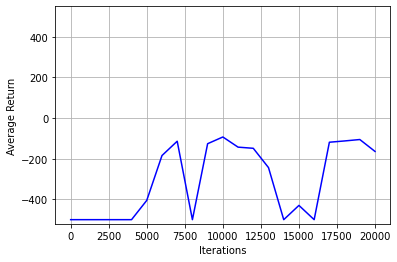

In [ ]:


iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns, '-b')
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.grid(True)
plt.ylim(top=550)

### Videos

Charts are nice. But more exciting is seeing an agent actually performing a task in an environment. 

First, create a function to embed videos in the notebook.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

Now iterate through a few episodes of the Cartpole game with the agent. The underlying Python environment (the one "inside" the TensorFlow environment wrapper) provides a `render()` method, which outputs an image of the environment state. These can be collected into a video.

In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render(mode='rgb_array'))
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)




create_policy_eval_video(agent.policy, "trained-agent")